In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/download')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: riamahajan
Your Kaggle Key: ··········


100%|██████████| 3.10G/3.10G [00:25<00:00, 129MB/s]


In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
imagePatches = glob('/content/breast-histopathology-images/10264/**/*', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/breast-histopathology-images/10264/0
/content/breast-histopathology-images/10264/1
/content/breast-histopathology-images/10264/0/10264_idx5_x2251_y351_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x601_y2101_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x2401_y1101_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x1751_y501_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x801_y751_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x2351_y1151_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x2051_y551_class0.png
/content/breast-histopathology-images/10264/0/10264_idx5_x2601_y951_class0.png


In [ ]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [ ]:
len(class1+class0)

1206

In [ ]:
sampled_class0 = random.sample(class0, 589)
sampled_class1 = random.sample(class1, 589)
len(sampled_class0+sampled_class0)

1178

In [ ]:
img_size = 75

In [ ]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [ ]:
class0_array[1]

[array([[[127,  67, 118],
         [176, 142, 173],
         [220, 205, 225],
         ...,
         [170, 124, 210],
         [170, 123, 212],
         [173, 127, 215]],
 
        [[146,  93, 142],
         [188, 158, 188],
         [223, 209, 229],
         ...,
         [171, 125, 208],
         [181, 139, 216],
         [194, 158, 225]],
 
        [[167, 124, 168],
         [200, 175, 202],
         [223, 209, 231],
         ...,
         [173, 128, 207],
         [187, 149, 217],
         [205, 175, 230]],
 
        ...,
 
        [[181, 141, 219],
         [188, 153, 219],
         [191, 159, 220],
         ...,
         [205, 184, 207],
         [205, 176, 207],
         [199, 163, 203]],
 
        [[184, 146, 222],
         [184, 147, 221],
         [182, 145, 219],
         ...,
         [197, 162, 214],
         [194, 153, 212],
         [188, 143, 207]],
 
        [[190, 155, 225],
         [182, 145, 223],
         [175, 133, 220],
         ...,
         [173, 118, 201],
  

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
# print(X[11].reshape(-1, 50, 50, 3))
# reshape X data
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [ ]:
X.shape

(1176, 75, 75, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(882, 75, 75, 3) (294, 75, 75, 3) (882, 2) (294, 2)


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Model Summary

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

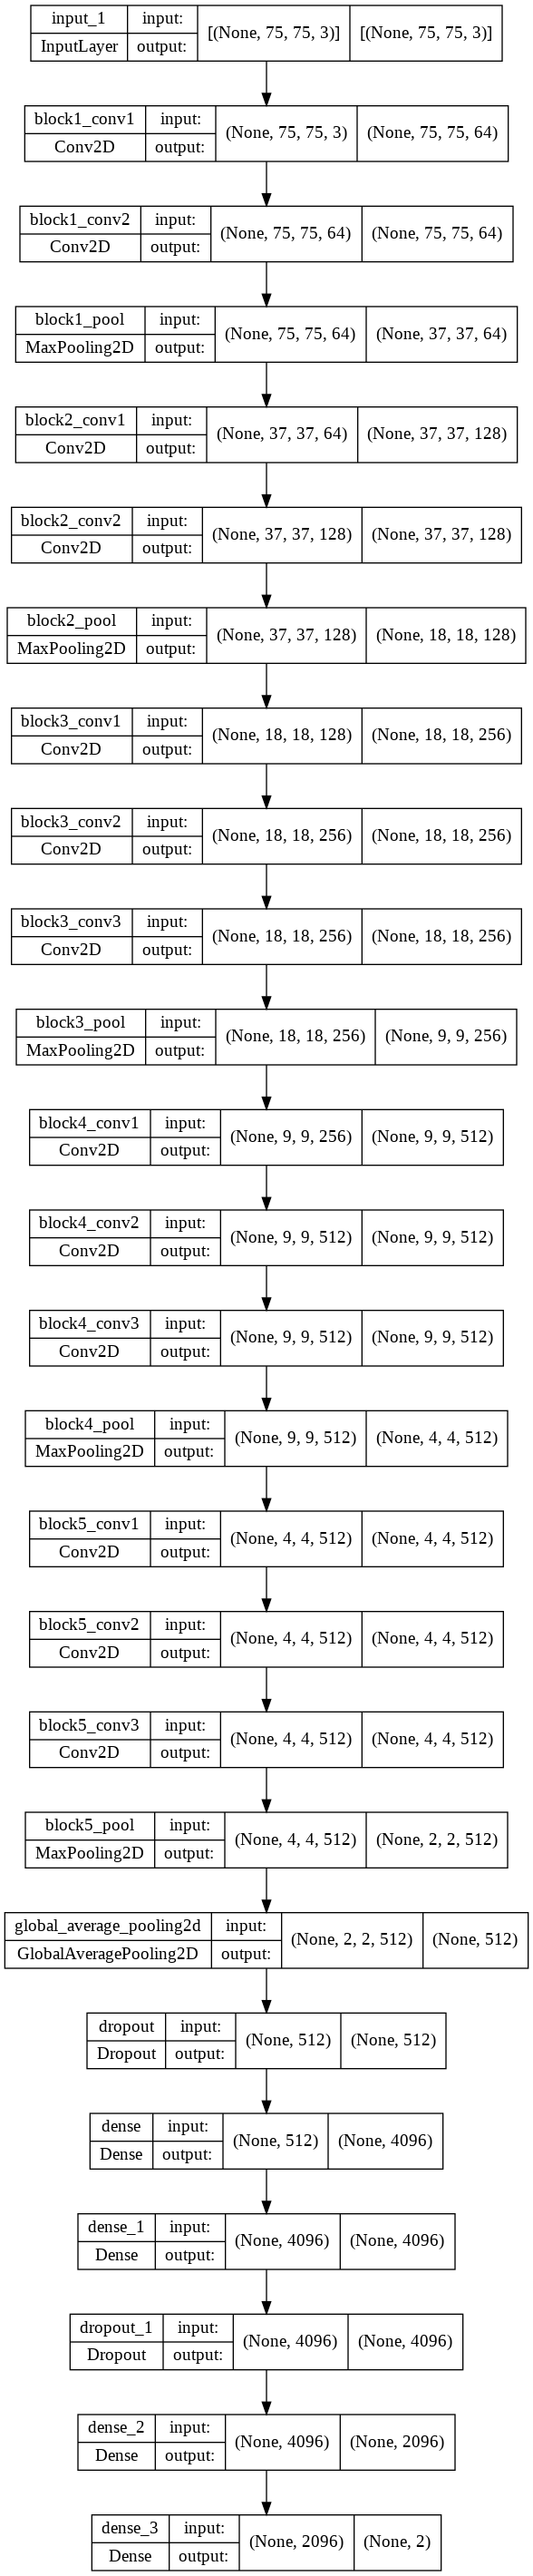

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,batch_size=32,epochs = 50,callbacks=callbacks)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/50
28/28 [==============================] - 74s 3s/step - loss: 0.2274 - accuracy: 0.9127 - val_loss: 0.1298 - val_accuracy: 0.9490
Epoch 2/50
28/28 [==============================] - 73s 3s/step - loss: 0.1418 - accuracy: 0.9478 - val_loss: 0.1274 - val_accuracy: 0.9490
Epoch 3/50
28/28 [==============================] - 72s 3s/step - loss: 0.1393 - accuracy: 0.9512 - val_loss: 0.1891 - val_accuracy: 0.9490
Epoch 4/50
28/28 [==============================] - 78s 3s/step - loss: 0.1080 - accuracy: 0.9592 - val_loss: 0.0857 - val_accuracy: 0.9762
Epoch 5/50
28/28 [==============================] - 72s 3s/step - loss: 0.0785 - accuracy: 0.9705 - val_loss: 0.1346 - val_accuracy: 0.9558
Epoch 6/50
28/28 [==============================] - 71s 3s/step - loss: 0.1364 - accuracy: 0.9467 - val_loss: 0.1359 - val_accuracy: 0.9320
Epoch 7/50
28/28 [==============================] - 83s 3s/step - loss: 0.0700 - accuracy: 0

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

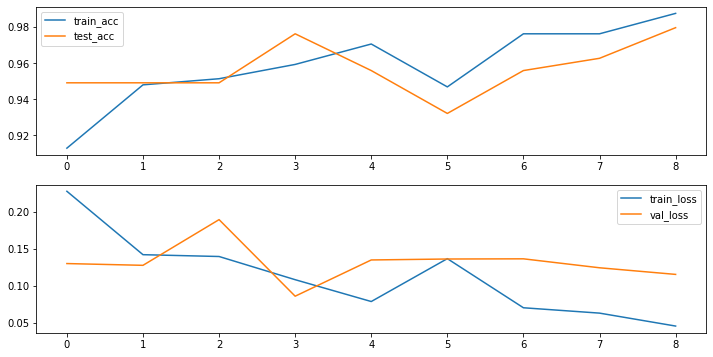

In [ ]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

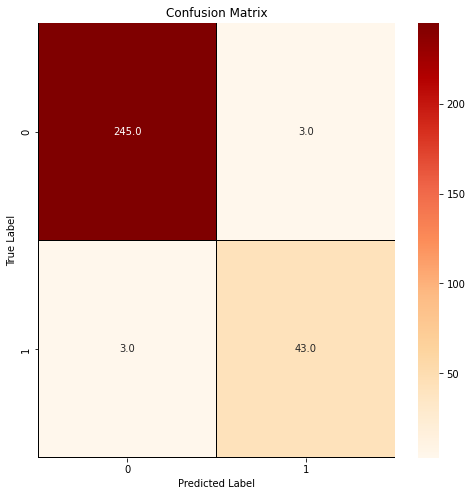

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       248
           1       0.93      0.93      0.93        46

    accuracy                           0.98       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.98      0.98      0.98       294



In [ ]:
model.save("model.h5")

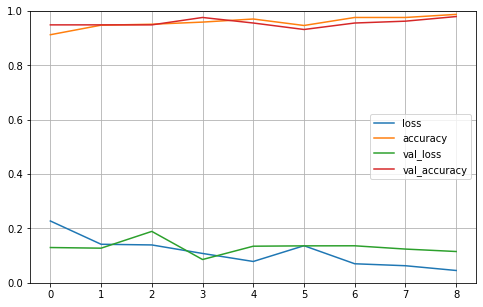

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()